In [1]:
#!/usr/bin/env python3

from smodels.base import runtime
from smodels.base.physicsUnits import TeV
from smodels.matching.theoryPrediction import theoryPredictionsFor,TheoryPredictionsCombiner
from smodels.tools import coverage
from smodels.base.crossSection import getXsecFromSLHAFile,XSection,XSectionList
from smodels.base.smodelsLogging import setLogLevel
from smodels.tools.particlesLoader import load
from smodels.share.models.SMparticles import SMList
from smodels.base.model import Model
from smodels.base.genericSMS import GenericGraph
from smodels.decomposition.decomposer import getDecayNodes
from smodels.base.particleNode import ParticleNode
import itertools

import pyslha
import time
setLogLevel("error")

In [2]:
slhafile = 'inputFiles/slha/TRV1_1800_300_300.slha'
#slhafile = 'inputFiles/slha/TN1N1_tchannel.slha'

In [3]:
# Load the BSM model
runtime.modelFile = slhafile
BSMList = load()
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile)

In [4]:
print(model)

Model: inputFiles/slha/TRV1_1800_300_300.slha


In [5]:
#Notice that the .updateParticles() method is apparently responsible for filling the decays attribute in particle classes
#(specifically, by calling .getModelDataFrom(inputFile) to build the decaysDict dictionary);
#since it only updates the .BSMParticles attribute, trying to use .decays in the listing of .allBSMParticles will always
#return an error due to the class not containing the decays attribute. The same applies if trying to loop over
#.SMparticles, which seem to also not contain the decays by default. 


### List Cross-Sections

In [6]:
for xsec in model.xsections:
    print(xsec.full_pid)

(2212, 2212, 55)


### List Decays

In [7]:
for mom in model.BSMparticles:
    momNode = ParticleNode(mom)
    decayNodesList = getDecayNodes(momNode)
    if not decayNodesList:
        continue
    print(decayNodesList)

[(y1, [xd, xd~], 0.7), (y1, [q, q], 0.15), (y1, [q, q], 0.15)]


In [8]:
vertices = []
for decay in decayNodesList:
    mom = decay[0]
    #mom_conj = decay[0].chargeConjugate()
    daughters = decay[1][:]
    #daughters_conj = [part.chargeConjugate() for part in decay[1][:]]
    vertexGraph = GenericGraph()
    #vertexGraph_conj = GenericGraph()
    vertexGraph.add_node(mom)
    vertexGraph.add_nodes_from(daughters)

    #vertexGraph_conj.add_node(mom_conj)
    #vertexGraph_conj.add_nodes_from(daughters_conj)
    # We do not yet have the structure to deal with non-directed (non-tree) graphs
    vertexGraph.add_edges_from([(0,1),(1,2),(2,0)])
    #vertexGraph_conj.add_edges_from([(0,1),(1,2),(2,0)])
    vertices.append(vertexGraph)
    #conj_vertices.append(vertexGraph_conj)

In [9]:
vertices

[(y1 > [xd]),(xd > [xd~]),(xd~ > [y1]),
 (y1 > [q]),(q > [q]),(q > [y1]),
 (y1 > [q]),(q > [q]),(q > [y1])]

(y1 > [xd]),(xd > [xd~]),(xd~ > [y1])
[(0, 55), (1, 52), (2, -52)]


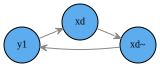

(y1 > [q]),(q > [q]),(q > [y1])
[(0, 55), (1, [-2, 1, 3, -1, -3, 2]), (2, [-2, 1, 3, -1, -3, 2])]


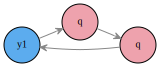

(y1 > [q]),(q > [q]),(q > [y1])
[(0, 55), (1, [-2, 1, 3, -1, -3, 2]), (2, [-2, 1, 3, -1, -3, 2])]


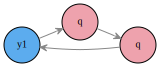

In [10]:
for vertexGraph in vertices:
    print(vertexGraph)
    print(list(zip(vertexGraph.nodeIndices,vertexGraph.pdg)))
    vertexGraph.draw()

In [11]:
def simpleConj(model, part):
    if part.pdg in {21,22,23}:
        return part
    elif part.pdg in {-21,-22,-23}:
        return part.chargeConjugate()
    elif any(p.pdg == -part.pdg for p in model.BSMparticles):
        return part.chargeConjugate()
    return part

def simpleConj_pdg(model, part_pdg):
    '''
    Receives a model class and the pdg number of a particle, and returns the pdg corresponding to its conjugate. In the case where it is self-conjugate, instead it returns abs(part_pdg). The verification of selfconjugation relies on a conjugate with (conjugate_pdg = -part_pdg) not existing in the model among the BSMParticles. SM states are filtered separately due to subtleties in implementation.

    :return: an int containing the pdg of the conjugate particle
    '''

    all_pdgs = [p.pdg for p in model.singleParticles]
    if part_pdg in {21,22,23}:
        return part_pdg
    elif part_pdg in {-21,-22,-23}:
        return -part_pdg
    elif any(p == -part_pdg for p in all_pdgs):
        return -part_pdg
    return part_pdg

def fstToist(vertex, part, model):
    ist = vertex['ist'].copy()
    fst = vertex['fst'].copy()
    try:
        fst.remove(part)
        #print("Part removed from final state: ",part)
        ist_part = simpleConj_pdg(model, part)
        #print("Particle to be added to the initial state: ",ist_part)
    except:
        # logger.error("Final state does not contain the specified particle.")
        print("Final state: ",fst)
        return
    ist.append(ist_part)
    return {'ist':ist,'fst':fst}

def istTofst(vertex,part, model):
    ist = vertex['ist'].copy()
    fst = vertex['fst'].copy()
    try:
        ist.remove(part)
    except:
        # logger.error("Final state does not contain the specified particle.")
        print("Initial state: ",ist)
    fst.append(simpleConj_pdg(model, part))
    return {'ist':ist,'fst':fst}

In [12]:
def generate_vertices(model):
    decays = []
    for ptc in model.BSMparticles:
        decaylist = ptc.decays
        for decay in decaylist:
            decays.append([ptc.pdg,decay.ids])
    
    proto_vertices=[]
    for decay in decays:
        proto_vertices.append({'ist':[decay[0]],'fst':decay[1]})
    
    vertices = []
    for vert in proto_vertices:
        while vert['ist']:
            ptc = vert['ist'][0]
            vert = istTofst(vert,ptc,model)
            for part in vert['fst']:
                vertices.append(fstToist(vert,part,model))
    return vertices

In [13]:
allvertices = generate_vertices(model)

In [14]:
def build_quark_ists(model,vert_list):
    ists = []
    for vert in vert_list:
        #print(vert['fst'])
        if vert['fst'] in tuple([q1,q2] for q1 in range(-3,4) for q2 in range(-3,4)):
            #Commented should be the final form of this code, after parsing through the vertex listings
            #two_to_one[tuple(vert['fst'])] = {'ist':vert['ist'].copy(),'fst':vert['fst'].copy()}
            #Below is a temporary implementation, assuming all vertices are triples, and u,d,s quark decays
            #two_to_one.append({'ist':{'ist':vert['fst'].copy(),'fst':vert['ist'].copy()},'fst':{'fst':vert['ist'].copy()}})
            ists.append({'ist':vert['fst'].copy(),'fst':vert['ist'].copy()})
    return ists

def build_mixed_ists(model,vert_list):
    ists = []
    for vert in vert_list:
        if any(vert['ist'][0] == p.pdg for p in model.BSMparticles):
            for ptc in vert['fst']:
                if abs(ptc) == 22 or any(ptc == p.pdg for p in model.getParticle(label='q').particles):
                    conj_vert = fstToist(vert,ptc,model)
                    ists.append({'ist':conj_vert['ist'],'fst':conj_vert['fst']})
                    #ists.append({'ist':conj_vert['fst'],'fst':conj_vert['ist']})
    return ists


def build_2to1(model,vert_list):
    diagrams = []
    ists = build_quark_ists(model,vert_list)
    for ist in ists:
        diagrams.append({'ist':ist,'fst':{'fst':ist['fst']}})
    return diagrams


def build_2to2(model, vert_list):
    schannel = []
    tchannel = []
    halfchannel = build_quark_ists(model,vert_list)
    for instates in halfchannel:
        for vert in vert_list:
            if vert['ist']==instates['fst']:
                schannel.append({'ist':instates, 'fst':vert})

    halfchannel = build_mixed_ists(model,vert_list)
    for instates in halfchannel:
        for vert in vert_list:
            if vert['ist']==instates['fst']:
                tchannel.append({'ist':instates, 'fst':vert})

    return schannel,tchannel

In [15]:
testeists = build_quark_ists(model,allvertices)
print(testeists)

[{'ist': [1, -1], 'fst': [55]}, {'ist': [2, -2], 'fst': [55]}]


In [16]:
tto = build_2to1(model,allvertices)
ttt_s,ttt_t = build_2to2(model,allvertices)
print('2-to-1 processes: \n',tto,'\n')
print('s-channel 2-to-2 processes: \n',ttt_s,'\n')
print('t-channel 2-to-2 processes: \n', ttt_t)

2-to-1 processes: 
 [{'ist': {'ist': [1, -1], 'fst': [55]}, 'fst': {'fst': [55]}}, {'ist': {'ist': [2, -2], 'fst': [55]}, 'fst': {'fst': [55]}}] 

s-channel 2-to-2 processes: 
 [{'ist': {'ist': [1, -1], 'fst': [55]}, 'fst': {'ist': [55], 'fst': [52, -52]}}, {'ist': {'ist': [1, -1], 'fst': [55]}, 'fst': {'ist': [55], 'fst': [1, -1]}}, {'ist': {'ist': [1, -1], 'fst': [55]}, 'fst': {'ist': [55], 'fst': [2, -2]}}, {'ist': {'ist': [2, -2], 'fst': [55]}, 'fst': {'ist': [55], 'fst': [52, -52]}}, {'ist': {'ist': [2, -2], 'fst': [55]}, 'fst': {'ist': [55], 'fst': [1, -1]}}, {'ist': {'ist': [2, -2], 'fst': [55]}, 'fst': {'ist': [55], 'fst': [2, -2]}}] 

t-channel 2-to-2 processes: 
 [{'ist': {'ist': [55, -1], 'fst': [-1]}, 'fst': {'ist': [-1], 'fst': [-1, 55]}}, {'ist': {'ist': [55, 1], 'fst': [1]}, 'fst': {'ist': [1], 'fst': [1, 55]}}, {'ist': {'ist': [55, -2], 'fst': [-2]}, 'fst': {'ist': [-2], 'fst': [-2, 55]}}, {'ist': {'ist': [55, 2], 'fst': [2]}, 'fst': {'ist': [2], 'fst': [2, 55]}}]


In [17]:
def print_diagram(process):
    testgraph = GenericGraph()
    # process = tto[0]
    node_index = 0
    unpacked_ist = [list((item)) for item in process['ist'].values()]
    unpacked_fst = [list((item)) for item in process['fst'].values()]

    ist_nodes_index = []
    fst_nodes_index = []

    for sts in unpacked_ist:
        ist_nodes_line = []
        for el in sts:
            testgraph.add_node(model.pdgToParticle(pdg=el),nodeIndex=node_index)
            ist_nodes_line.append(node_index)
            node_index+=1
        ist_nodes_index.append(ist_nodes_line)

    prop_edge = (node_index-1,node_index)

    for sts in unpacked_fst:
        fst_nodes_line = []
        for el in sts:
            testgraph.add_node(model.pdgToParticle(pdg=el),nodeIndex=node_index)
            fst_nodes_line.append(node_index)
            node_index+=1
        fst_nodes_index.append(fst_nodes_line)

    ist_edges = list(itertools.product(*ist_nodes_index))
    testgraph.add_edges_from(ist_edges)
    
    if len(fst_nodes_index) > 1:
        fst_edges = list(itertools.product(*fst_nodes_index))
        testgraph.add_edges_from(fst_edges)

    testgraph.add_edge(*prop_edge)
    testgraph.draw()



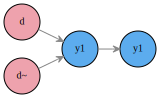

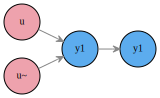

In [18]:
for process in tto:
    print_diagram(process)

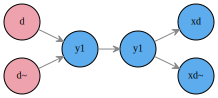

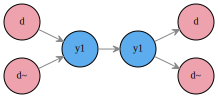

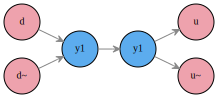

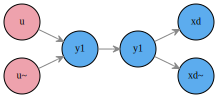

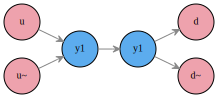

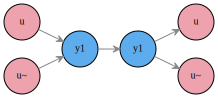

In [19]:
for process in ttt_s:
    print_diagram(process)

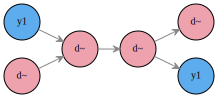

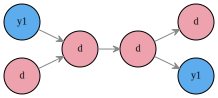

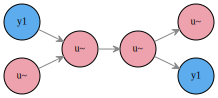

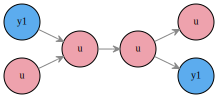

In [20]:
for process in ttt_t:
    print_diagram(process)

In [21]:
def generate_xsecs(model):
    fsts = []
    for xsec in model.xsections:
        fsts.append(xsec.pid)
    return fsts

{(55,): [{'ist': {'ist': [1, -1], 'fst': [55]}, 'fst': {'fst': [55]}}, {'ist': {'ist': [2, -2], 'fst': [55]}, 'fst': {'fst': [55]}}]}


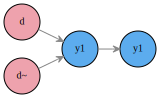

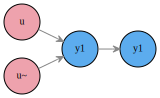

In [22]:
xsecs = generate_xsecs(model)
dgms = {}
for xsec in xsecs:
    dgms[xsec] = []
    for process in tto:
        if sorted(list(xsec)) == sorted(process['fst']['fst']):
            dgms[xsec].append(process)
    for process in ttt_s:
        if sorted(list(xsec)) == sorted(process['fst']['fst']):
            dgms[xsec].append(process)
    for process in ttt_t:
        sort_xsec = sorted(list(xsec))
        sort_left = sorted(process['ist']['ist'],key=abs)
        sort_right = sorted(process['fst']['fst'],key=abs)
        sort_ist = [sort_left[0],sort_right[0]]
        sort_fst = [sort_left[1],sort_right[1]]
        if sort_xsec == sort_fst:
            dgms[xsec].append(process)
print(dgms)
for xsec in xsecs:
    for process in dgms[xsec]:
        print_diagram(process)